## $$Exploratory\ Data\ Analysis$$

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from src import get_data, clean_data, add_features

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale = 1.5)

In [149]:
# data preprocessing
path = 'https://github.com/EuMentality/datasets/raw/main/taxi_trip.csv'
df = get_data(path)

In [150]:
df.shape

(1458644, 11)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### <center> Data Cleaning

#### Choosing 1 vendor_id to simplify

In [152]:
df.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [153]:
df.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [154]:
df = df[(df.vendor_id == 1) & (df.store_and_fwd_flag == "N")]

In [155]:
df = df[df.passenger_count != 0]

#### Selecting Relevant Trips in Manhattan

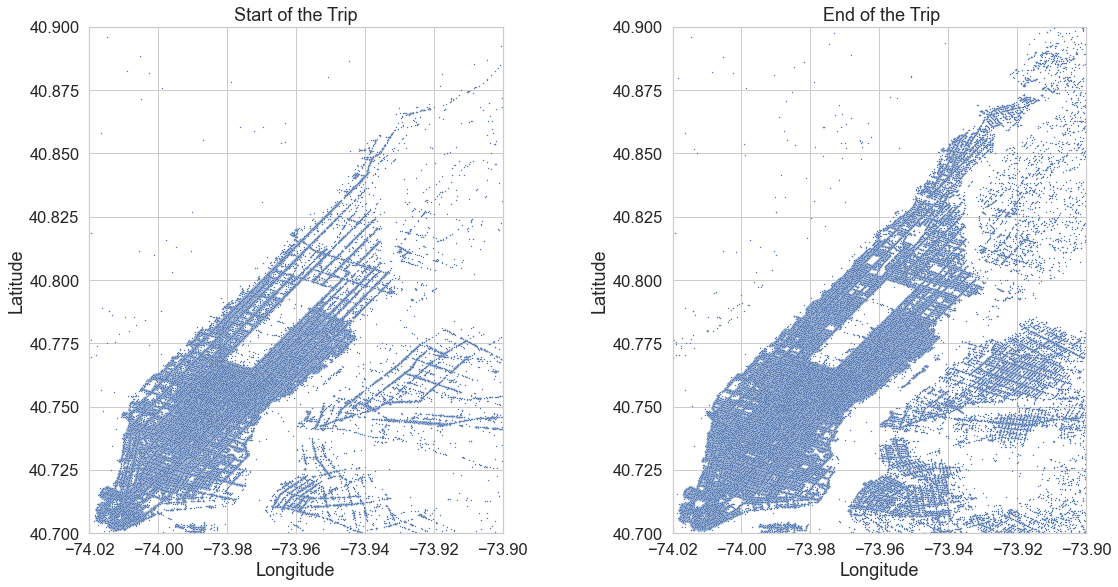

In [156]:
# Scatter Plot for Start/End trip 
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.tight_layout(w_pad=7)
long_lat_set = [('pickup_longitude', 'pickup_latitude'), ('dropoff_longitude', 'dropoff_latitude')]
scatter_name = ['Start of the Trip', ' End of the Trip']
for k, ((longitude, latitude), ax_name) in enumerate(zip(long_lat_set, scatter_name)):
    sns.scatterplot(x=df[longitude], y=df[latitude], s=2, ax=axes[k])
    axes[k].set_title(ax_name)
    axes[k].set_xlabel('Longitude')
    axes[k].set_ylabel('Latitude')
    axes[k].set_ylim(40.70, 40.90)
    axes[k].set_xlim(-74.02,-73.90)

In [157]:
def find_line(A: tuple[float, float], B: tuple[float, float]):
    """Function determines the coefficients of the equation of a straight line by two points.
    """
    y_1, x_1 = A
    y_2, x_2 = B
    k = (y_2 - y_1)/(x_2 - x_1)
    b = y_1 - k*x_1
    return k, b

In [158]:
# 13 Bridges in Manhattan
coords = {}
coords['middle_henry_bridge'] = (40.877758, -73.922214)
coords['middle_broadway_bridge'] = (40.873689, -73.910933)
coords['middle_washington_bridge'] = (40.851470, -73.952140)
coords['middle_linkoln_tunnel'] = (40.762886, -74.009588)
coords['middle_holland_tunnel'] = (40.727318, -74.021006)
coords['middle_brooklyn_bridge'] = (40.704914, -73.995546)
coords['middle_williamsburg_bridge'] = (40.713333, -73.971641)
coords['middle_midtown_tunnel'] = (40.744429, -73.963135)
coords['middle_quins_bridge'] = (40.755947, -73.952374)
coords['middle_kennedy_bridge'] = (40.798973, -73.919060)
coords['middle_avenue_bridge'] = (40.807628, -73.932374)
coords['middle_river_bridge'] = (40.834455, -73.934541)
coords['middle_heights_bridge'] = (40.862674, -73.914647)


In [159]:
# Building Borders
borders_coefs = {}
borders_list = [('middle_henry_bridge', 'middle_broadway_bridge'), ('middle_washington_bridge', 'middle_linkoln_tunnel'),
                ('middle_linkoln_tunnel', 'middle_holland_tunnel'), ('middle_brooklyn_bridge', 'middle_williamsburg_bridge'),
                ('middle_williamsburg_bridge', 'middle_midtown_tunnel'), ('middle_midtown_tunnel', 'middle_quins_bridge'),
                ('middle_kennedy_bridge', 'middle_avenue_bridge'), ('middle_avenue_bridge', 'middle_river_bridge'),
                ('middle_river_bridge', 'middle_heights_bridge')]
for border in borders_list:
    a, b = border
    borders_coefs[f'{a.split("_")[1]}_{b.split("_")[1]}_path'] = find_line(coords[a], coords[b])

for border_path, border_coef in borders_coefs.items():
    k, b = border_coef
    df[f'{border_path}_drop'] = k*df.dropoff_longitude + b
    df[f'{border_path}_pick'] = k*df.pickup_longitude + b
    df[f'{border_path}_drop_2'] = k*df.dropoff_longitude + b
    df[f'{border_path}_pick_2'] = k*df.pickup_longitude + b

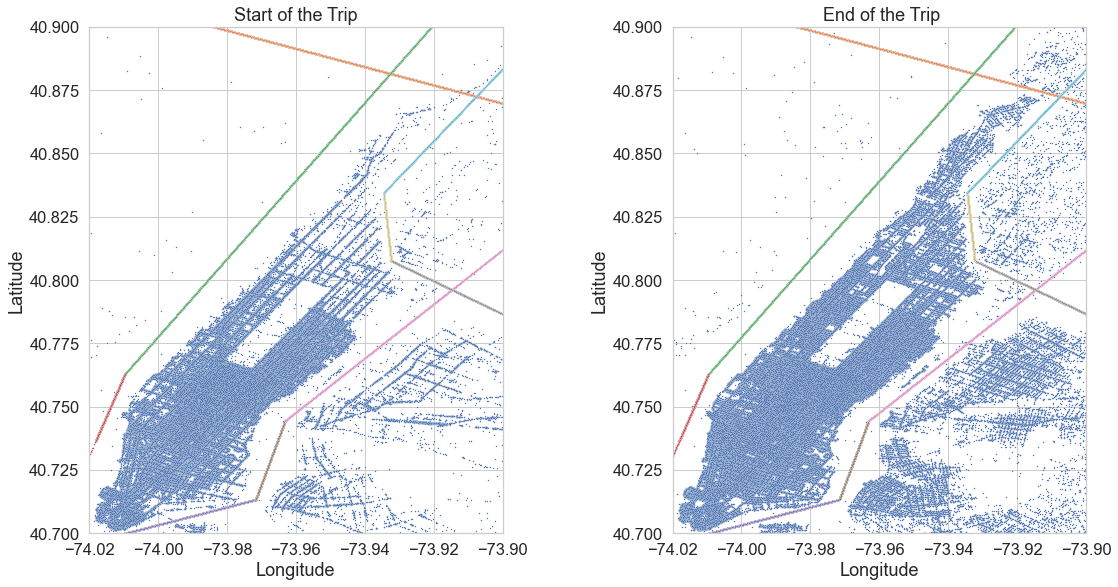

In [160]:
# Vizualization
## 1
### pick
mask_1_pick = df.pickup_longitude >= coords['middle_linkoln_tunnel'][1]
df.washington_linkoln_path_pick_2 = df.washington_linkoln_path_pick_2*mask_1_pick
df.linkoln_holland_path_pick_2 = df.linkoln_holland_path_pick_2*(~mask_1_pick)
### drop
mask_1_drop = df.dropoff_longitude >= coords['middle_linkoln_tunnel'][1]
df.washington_linkoln_path_drop_2 = df.washington_linkoln_path_drop_2*mask_1_drop
df.linkoln_holland_path_drop_2 = df.linkoln_holland_path_drop_2*(~mask_1_drop)

## 2 
### pick
mask_2_pick = df.pickup_longitude <= coords['middle_williamsburg_bridge'][1]
df.brooklyn_williamsburg_path_pick_2 = df.brooklyn_williamsburg_path_pick_2*mask_2_pick
df.williamsburg_midtown_path_pick_2 = df.williamsburg_midtown_path_pick_2*(~mask_2_pick)
### drop
mask_2_drop = df.dropoff_longitude <= coords['middle_williamsburg_bridge'][1]
df.brooklyn_williamsburg_path_drop_2 = df.brooklyn_williamsburg_path_drop_2*mask_2_drop
df.williamsburg_midtown_path_drop_2 = df.williamsburg_midtown_path_drop_2*(~mask_2_drop)

## 3 
### pick
mask3_pick = df.pickup_longitude <= coords['middle_midtown_tunnel'][1]
df.williamsburg_midtown_path_pick_2 = df.williamsburg_midtown_path_pick_2*mask3_pick
df.midtown_quins_path_pick_2 = df.midtown_quins_path_pick_2*(~mask3_pick)
### drop
mask3_drop = df.dropoff_longitude <= coords['middle_midtown_tunnel'][1]
df.williamsburg_midtown_path_drop_2 = df.williamsburg_midtown_path_drop_2*mask3_drop
df.midtown_quins_path_drop_2 = df.midtown_quins_path_drop_2*(~mask3_drop)

## 4 
### pick
mask3_pick = df.pickup_longitude >= coords['middle_avenue_bridge'][1]
df.kennedy_avenue_path_pick_2 = df.kennedy_avenue_path_pick_2*mask3_pick
df.avenue_river_path_pick_2 = df.avenue_river_path_pick_2*(~mask3_pick)
### drop
mask3_drop = df.dropoff_longitude >= coords['middle_avenue_bridge'][1]
df.kennedy_avenue_path_drop_2 = df.kennedy_avenue_path_drop_2*mask3_drop
df.avenue_river_path_drop_2 = df.avenue_river_path_drop_2*(~mask3_drop)

## 5 
### pick
mask3_pick = df.pickup_longitude >= coords['middle_river_bridge'][1]
df.river_heights_path_pick_2 = df.river_heights_path_pick_2*mask3_pick
df.avenue_river_path_pick_2 = df.avenue_river_path_pick_2*(mask3_pick)
### drop
mask3_drop = df.dropoff_longitude >= coords['middle_river_bridge'][1]
df.river_heights_path_drop_2 = df.river_heights_path_drop_2*mask3_drop
df.avenue_river_path_drop_2 = df.avenue_river_path_drop_2*(mask3_drop)


## Scatter Plot for Start/End trip 
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.tight_layout(w_pad=7)
long_lat_set = [('pickup_longitude', 'pickup_latitude'), ('dropoff_longitude', 'dropoff_latitude')]
scatter_name = ['Start of the Trip', ' End of the Trip']
type_path = ['pick', 'drop']
for k, ((longitude, latitude), ax_name, type) in enumerate(zip(long_lat_set, scatter_name, type_path)):
    sns.scatterplot(x=df[longitude], y=df[latitude], s=2, ax=axes[k])    
    sns.scatterplot(x=df[longitude], y=df[f'henry_broadway_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'washington_linkoln_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'linkoln_holland_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'brooklyn_williamsburg_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'williamsburg_midtown_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'midtown_quins_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'kennedy_avenue_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'avenue_river_path_{type}_2'], s=2, ax=axes[k])
    sns.scatterplot(x=df[longitude], y=df[f'river_heights_path_{type}_2'], s=2, ax=axes[k])
    axes[k].set_title(ax_name)
    axes[k].set_xlabel('Longitude')
    axes[k].set_ylabel('Latitude')
    axes[k].set_ylim(40.70, 40.90)
    axes[k].set_xlim(-74.02,-73.90)

In [161]:
# Filtering Irrelevant Trips
mask_0_1 = df.henry_broadway_path_pick >= df.pickup_latitude
mask_0_2 = df.henry_broadway_path_drop >= df.dropoff_latitude
mask_0 = mask_0_1 & mask_0_2

mask_1_1 = df.washington_linkoln_path_pick >= df.pickup_latitude
mask_1_2 = df.washington_linkoln_path_drop >= df.dropoff_latitude
mask_1 = mask_1_1 & mask_1_2

mask_2_1 = df.linkoln_holland_path_pick >= df.pickup_latitude
mask_2_2 = df.linkoln_holland_path_drop >= df.dropoff_latitude
mask_2 = mask_2_1 & mask_2_2

mask_3_1 = df.brooklyn_williamsburg_path_pick <= df.pickup_latitude
mask_3_2 = df.brooklyn_williamsburg_path_drop <= df.dropoff_latitude
mask_3 = mask_3_1 & mask_3_2

mask_4_1 = df.williamsburg_midtown_path_pick <= df.pickup_latitude
mask_4_2 = df.williamsburg_midtown_path_drop <= df.dropoff_latitude
mask_4 = mask_4_1 & mask_4_2

mask_5_1 = df.midtown_quins_path_pick <= df.pickup_latitude
mask_5_2 = df.midtown_quins_path_drop <= df.dropoff_latitude
mask_5 = mask_5_1 & mask_5_2

mask_6_1 = df.kennedy_avenue_path_pick >= df.pickup_latitude
mask_6_2 = df.kennedy_avenue_path_drop >= df.dropoff_latitude
mask_6 = mask_6_1 & mask_6_2

mask_7_1 = df.avenue_river_path_pick >= df.pickup_latitude
mask_7_2 = df.avenue_river_path_drop >= df.dropoff_latitude
mask_7 = mask_7_1 & mask_7_2

mask_8_1 = df.river_heights_path_pick <= df.pickup_latitude
mask_8_2 = df.river_heights_path_drop <= df.dropoff_latitude
mask_8 = mask_8_1 & mask_8_2

mask = mask_0 & mask_1 & mask_2 & mask_3 & (mask_4 | mask_5) & ((mask_6 | mask_7 | mask_8))
df = df[mask].reset_index(drop=True)

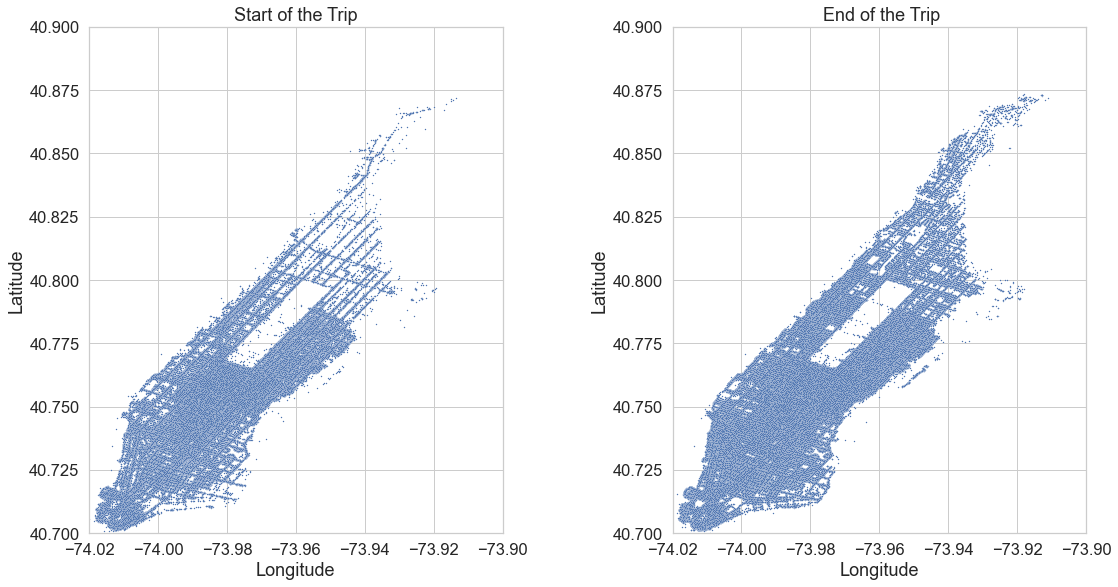

In [162]:
# Scatter Plot for Start/End trip after Cleaning
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.tight_layout(w_pad=7)
long_lat_set = [('pickup_longitude', 'pickup_latitude'), ('dropoff_longitude', 'dropoff_latitude')]
scatter_name = ['Start of the Trip', ' End of the Trip']
type_path = ['pick', 'drop']
for k, ((longitude, latitude), ax_name, type) in enumerate(zip(long_lat_set, scatter_name, type_path)):
    sns.scatterplot(x=df[longitude], y=df[latitude], s=2, ax=axes[k])    
    axes[k].set_title(ax_name)
    axes[k].set_xlabel('Longitude')
    axes[k].set_ylabel('Latitude')
    axes[k].set_ylim(40.70, 40.90)
    axes[k].set_xlim(-74.02,-73.90)

### Feature Preprocessing

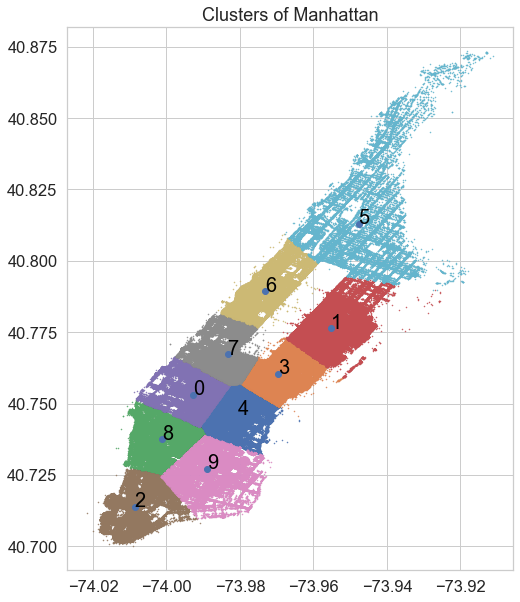

In [163]:
# Clusters
from sklearn.cluster import KMeans
df_pickup = df[['pickup_longitude', 'pickup_latitude']]
df_dropoff = df[['dropoff_longitude', 'dropoff_latitude']]
cols = ['longitude', 'latitude']
df_pickup.columns = cols
df_dropoff.columns = cols
df_fit = pd.concat([df_pickup, df_dropoff], ignore_index=True)
kmeans = KMeans(n_clusters=10, random_state=2).fit(df_fit)

df_fit['label'] = kmeans.labels_

plt.figure(figsize = (8,10))
for label in df_fit.label.unique():
    plt.plot(df_fit.longitude[df_fit.label == label],df_fit.latitude[df_fit.label == label],'.', alpha=1, markersize=1)
    plt.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'b')
    plt.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'black', fontsize = 20, alpha=1)
plt.title('Clusters of Manhattan')
plt.show()


In [164]:
# add route features
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude', 'dropoff_latitude']].rename(columns={'dropoff_longitude': 'longitude', 'dropoff_latitude': 'latitude'}))
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']].rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude': 'latitude'}))
df['route'] = (df.dropoff_cluster.astype(str) + ' ' + df.pickup_cluster.astype(str)).str.split().apply(sorted).apply(lambda x: x[0] + '_' + x[1])

In [165]:
# Distance Estimation
meas_ang = 0.506 # 29 angle degree = 0.506 radian
df['diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()*111
df['diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()*80
df['Euclidean'] = (df.diff_latitude**2 + df.diff_longitude**2)**0.5 
df['delta_manh_long'] = (df.Euclidean*np.sin(np.arctan(df.diff_longitude / df.diff_latitude)-meas_ang)).abs()
df['delta_manh_lat'] = (df.Euclidean*np.cos(np.arctan(df.diff_longitude / df.diff_latitude)-meas_ang)).abs()
df['manh_length'] = df.delta_manh_long + df.delta_manh_lat
df.drop(['diff_latitude', 'diff_longitude', 'Euclidean', 'delta_manh_long', 'delta_manh_lat'], axis=1, inplace=True)

In [166]:
# Passenger Count
df['passenger_count'] = df['passenger_count'].apply(lambda x: 1 if (x < 5) else 2)

In [167]:
# time col to datetime
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
# month, weekday, hour of pickup date
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['high_traffic'] = df['pickup_hour'].apply(lambda x: 1 if  8 <= x <= 20 else 0)
# anomaly day
anomaly_days = [pd.to_datetime('2016-01-23'), pd.to_datetime('2016-01-24')]
df['anomaly'] = df.pickup_datetime.between(anomaly_days[0], anomaly_days[1], inclusive='both').astype(int)
df.drop('pickup_datetime', axis=1, inplace=True)

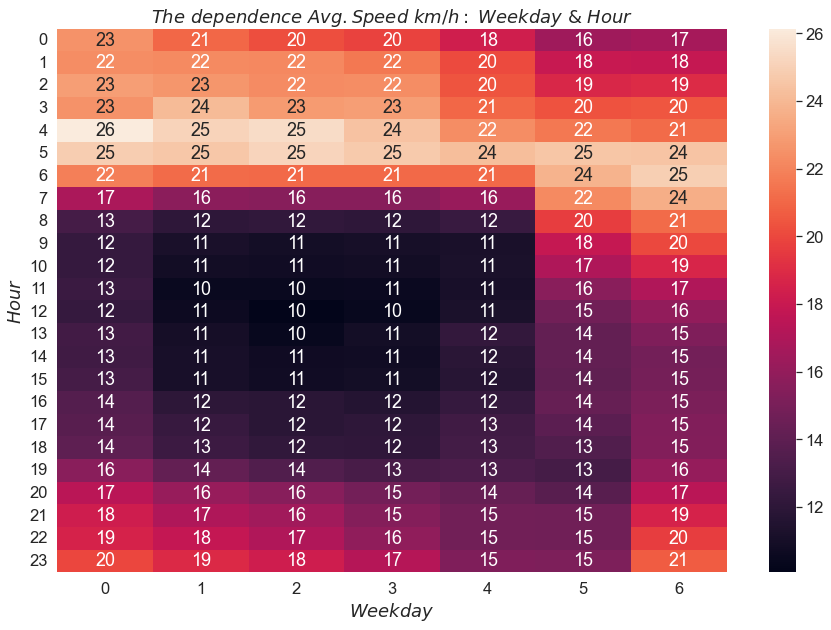

In [168]:
# Average speed km/h
df['trip_duration'] = np.log1p(df.trip_duration)
df['trip_duration_seconds'] = np.exp(df.trip_duration) - 1
df['avg_speed'] = df.manh_length / (df.trip_duration_seconds/60/60)

med_weekday_hour_speed = df\
                        .groupby(['pickup_weekday','pickup_hour'], as_index = False)\
                        .agg({'avg_speed':'median'})\
                        .rename(columns={'avg_speed': 'median_avg_speed'})

hour_weekday_speed = pd.pivot_table(data=med_weekday_hour_speed, 
                                    values='median_avg_speed', 
                                    index='pickup_hour',
                                    columns='pickup_weekday')


fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(hour_weekday_speed, annot = True)
ax.set_xlabel('$Weekday$')
ax.set_ylabel('$Hour$')
ax.set_title('$The\ dependence\ Avg.Speed\ km/h:\ Weekday\ &\ Hour$')
plt.yticks(rotation=0) 
plt.show()

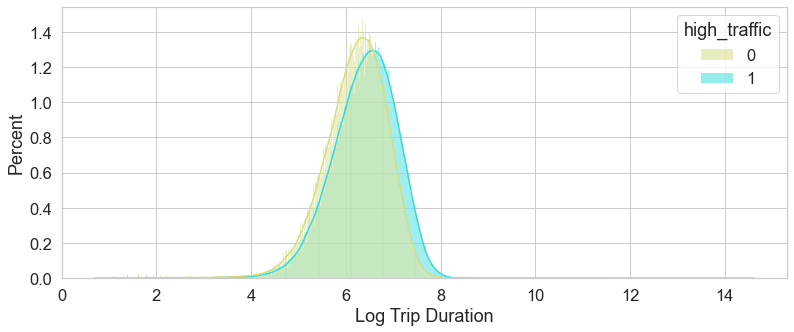

In [169]:
# Target Distribution Depending on High Traffic
fig, axes = plt.subplots(figsize=(13, 5))
ax = sns.histplot(data=df, x='trip_duration', kde=True, hue='high_traffic', palette='rainbow_r', stat='percent', common_norm=False)
ax.set_xlabel('Log Trip Duration')
plt.show()

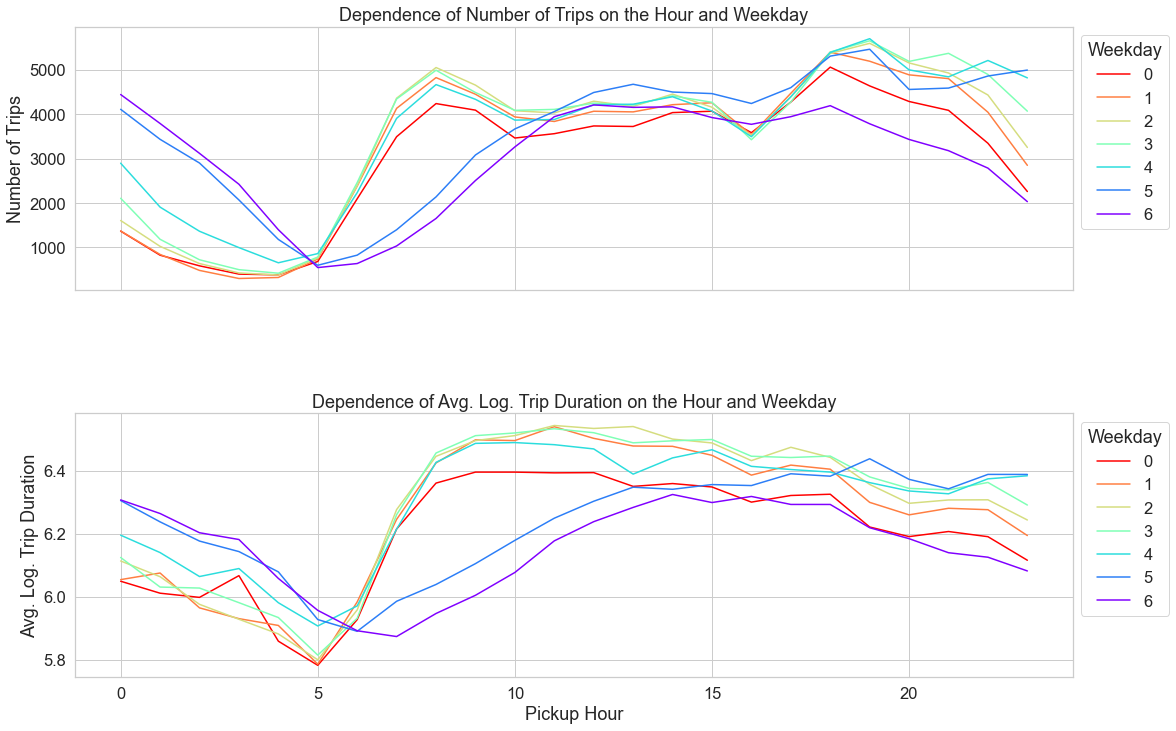

In [170]:
# Weekday and Hour
num_trips_hour_weekday = df\
                    .groupby(['pickup_hour','pickup_weekday'], as_index = [False, False])\
                    .agg({'avg_speed': 'count'})\
                    .rename(columns={'avg_speed': 'num_trips'})
time_trips_hour_weekday = df\
                .groupby(['pickup_hour','pickup_weekday'], as_index =[False, False])\
                .agg({'trip_duration': 'mean'})\
                .rename(columns={'trip_duration': 'mean_time_trips_hour_weekday'})


fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.tight_layout(h_pad=6)
for i, (y, data, y_label, title) in enumerate(zip(['num_trips', 'mean_time_trips_hour_weekday'],
                                           [num_trips_hour_weekday, time_trips_hour_weekday],
                                           ['Number of Trips', 'Avg. Log. Trip Duration'],
                                           ['Dependence of Number of Trips on the Hour and Weekday', 'Dependence of Avg. Log. Trip Duration on the Hour and Weekday'])):
    sns.lineplot(x='pickup_hour', y=y, hue = 'pickup_weekday', data=data, ax=axes[i], palette='rainbow_r')
    axes[i].set_xlabel('Pickup Hour')
    axes[i].set_ylabel(y_label)
    axes[i].set_title(title)
    axes[i].legend(bbox_to_anchor=(1, 1), loc=2, title='Weekday')